# Proyecto Computer Vision - Segunda Entrega

### Caso de uso generalizable para Object Tracking and People Tracking

**Autor**

- Adolfo Fuentes Jofré

## Introducción

### Problema o necesidad

Un problema recurrente en la optimización de Layout (posición de los productos) es generar áreas con mapas de calor que representan el flujo de clientes, esta información es útil para saber que zonas de la tienda son mas concurridas y tiene un mayor flujo de personas de manera tal de posicionar los productos de mayor valor para en negocio en esa zona y/o reoptimizar en Layout. Este problema es tranversal en mutiples Industrias desde Retail, Centros Comerciales hasta un Casino.


### Dataset

Video de camara de seguridad de personas caminando en un centro comercial. Video de uso gratuito (Free Stock video footage YouTube)

### Objetivos

Generar un sistema automatizado que permita:

- Realizar el Tracking de las personas caminando
- Delimitar en un cuadro a las personas y asignar un id distinto a cada persona
- Contar el flujo total de personas que transitan por una zona especifica

## Preprocesamiento

### Librerias



In [1]:
import torchvision
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, models, transforms as T

**Abrimos la Imagen**

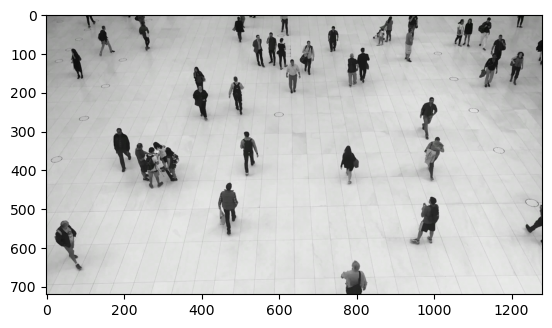

In [2]:
im = Image.open('Out\\frame0.jpg')
plt.imshow(im)

In [3]:
img = cv2.imread('Out\\frame0.jpg') # Read image with cv2
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

**Definimos un par de coordenadas**

In [4]:
coor=[(443.22217, 432.3046), (495.6839, 569.45807)]
coor

[(443.22217, 432.3046), (495.6839, 569.45807)]

In [5]:
aux=tuple(tuple(map(int, tup)) for tup in coor) # transforma a entero
cv2.rectangle(img, aux[0],aux[1],color=(0, 255, 0), thickness=3) 
cv2.putText(img,'Person',aux[0],  cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),thickness=3)

array([[[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [148, 150, 147],
        [149, 151, 148],
        [149, 151, 148]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [148, 150, 147],
        [149, 151, 148],
        [149, 151, 148]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [148, 150, 147],
        [148, 150, 147],
        [149, 151, 148]],

       ...,

       [[200, 202, 199],
        [201, 203, 200],
        [199, 201, 198],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[200, 202, 199],
        [200, 202, 199],
        [201, 203, 200],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[200, 202, 199],
        [199, 201, 198],
        [202, 204, 201],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]]

**Graficamos la imagen con el recuadro y el label "Person"**

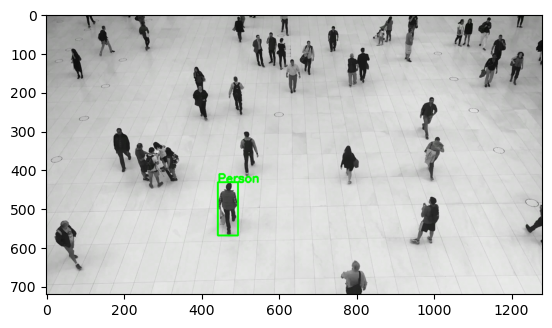

In [6]:
plt.imshow(img)

## Transfer Learning

**Importaremos una restnet pre-entrenada y el label de los disntos objetos que detecta**

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [

    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

C:\Users\Usuario\.conda\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\.conda\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Funciones

In [8]:
def get_prediction(img_path, threshold):
    """
    Realiza una predicción de detección de objetos en una imagen utilizando un modelo pre-entrenado.

    Parámetros:
    - img_path (str): Ruta de la imagen de entrada.
    - threshold (float): Umbral de confianza para filtrar las predicciones.

    Retorna:
    - pred_boxes1 (list): Lista de cajas delimitadoras (bounding boxes) de los objetos detectados en la imagen.
    - pred_class1 (list): Lista de clases de los objetos detectados en la imagen.

    """

    img = Image.open(img_path)  # Cargar la imagen
    transform = T.Compose([T.ToTensor()])  # Definir la transformación de PyTorch
    img = transform(img)  # Aplicar la transformación a la imagen

    pred = model([img])  # Pasar la imagen al modelo para obtener las predicciones

    # Obtener la clase de la predicción y su puntuación
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())

    # Filtrar las predicciones basadas en el umbral de confianza
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    # Filtrar solo las predicciones de la clase 'person'
    myIndices = [i for i in range(len(pred_class)) if pred_class[i] == 'person']
    pred_class1 = [pred_class[i] for i in myIndices]
    pred_boxes1 = [pred_boxes[i] for i in myIndices]

    return pred_boxes1, pred_class1

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    """
    Realiza la detección de objetos en una imagen y muestra el resultado visualmente.

    Parámetros:
    - img_path (str): Ruta de la imagen de entrada.
    - threshold (float, opcional): Umbral de confianza para filtrar las predicciones (por defecto es 0.5).
    - rect_th (int, opcional): Grosor del contorno de las cajas delimitadoras (por defecto es 3).
    - text_size (int, opcional): Tamaño del texto de las etiquetas (por defecto es 3).
    - text_th (int, opcional): Grosor del texto de las etiquetas (por defecto es 3).
    
    Retorna:
    - len(boxes): la cantidad de objetos (personas) detectados en la imagen.

    """

    boxes, pred_cls = get_prediction(img_path, threshold)  # Obtener las predicciones de detección de objetos

    img = cv2.imread(img_path)  # Leer la imagen utilizando OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir la imagen de BGR a RGB

    # Dibujar las cajas delimitadoras y etiquetas en la imagen
    for i in range(len(boxes)):
        aux = tuple(tuple(map(int, tup)) for tup in boxes[i])
        cv2.rectangle(img, aux[0], aux[1], color=(0, 255, 0), thickness=rect_th)  # Dibujar el contorno de la caja delimitadora
        cv2.putText(img, str(i), aux[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)  # Mostrar la etiqueta del objeto

    plt.figure(figsize=(20, 30))  
    plt.imshow(img)  
    plt.xticks([]) 
    plt.yticks([])  
    plt.show()  # Mostrar la figura
    
    return len(boxes)

### Predicción

In [9]:
boxes, pred_cls = get_prediction('Out\\frame0.jpg', 0.8)

In [10]:
boxes

[[(443.22217, 432.3046), (495.6839, 569.45807)],
 [(501.18707, 300.63504), (548.6047, 415.24503)],
 [(966.0561, 213.89882), (1010.95636, 321.63043)],
 [(775.5949, 99.51255), (807.30255, 185.5091)],
 [(173.25558, 290.7064), (221.5165, 404.7594)],
 [(1195.2103, 97.64532), (1234.1835, 183.02487)],
 [(974.37933, 314.29733), (1028.7239, 427.42883)],
 [(803.32416, 87.04374), (835.83984, 177.20128)],
 [(760.0624, 635.7334), (827.81213, 719.68994)],
 [(615.11206, 115.60903), (658.35144, 204.57394)],
 [(945.49585, 470.17923), (1012.7888, 586.4515)],
 [(759.35046, 338.6047), (807.22565, 437.8828)],
 [(133.52132, 29.448956), (174.58212, 107.219475)],
 [(471.4505, 159.81447), (511.04123, 257.3289)],
 [(228.30536, 330.32376), (267.24747, 428.82764)],
 [(59.997746, 87.70881), (95.77105, 168.62614)],
 [(1074.6514, 10.540487), (1103.3835, 83.69601)],
 [(378.01562, 178.02309), (418.84055, 270.67245)],
 [(260.2885, 342.58185), (302.42795, 447.8906)],
 [(1053.0913, 12.96877), (1081.9692, 81.528984)],
 [(

In [11]:
pred_cls

['person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person']

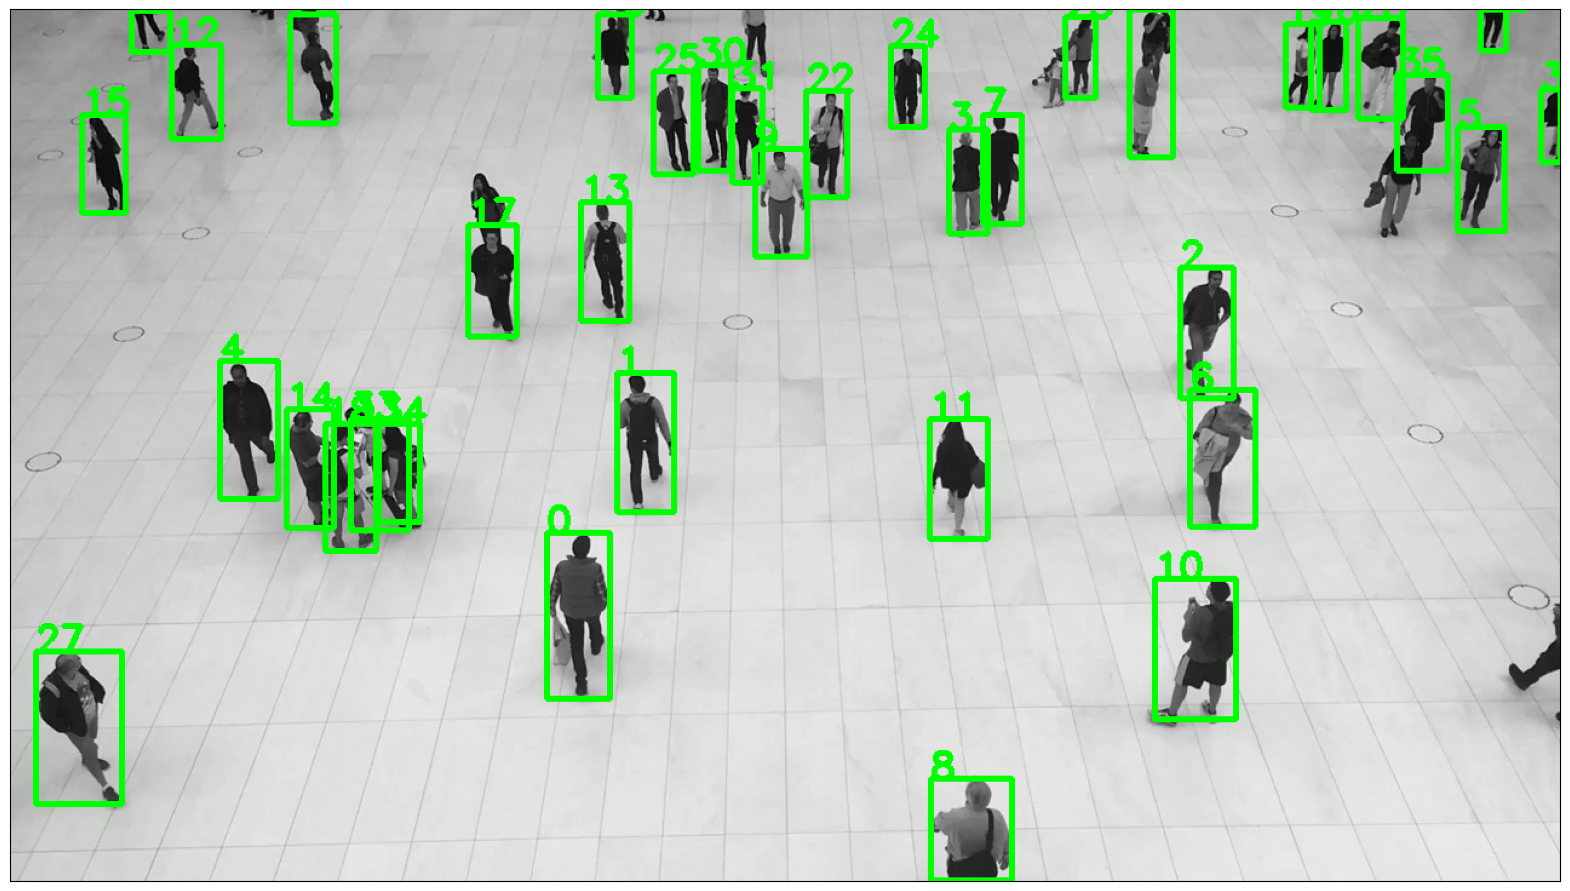

In [12]:
a=object_detection_api('Out\\frame0.jpg', threshold=0.8, text_size=1) 

In [13]:
a

37

**Detectó 37 personas en esta imagen**

### Analisis de Sensibilidad

Modificarémos los umbrales (threshold) de detección para ver como varía la detección de personas de la RestNet utilizando distintos umbrales.

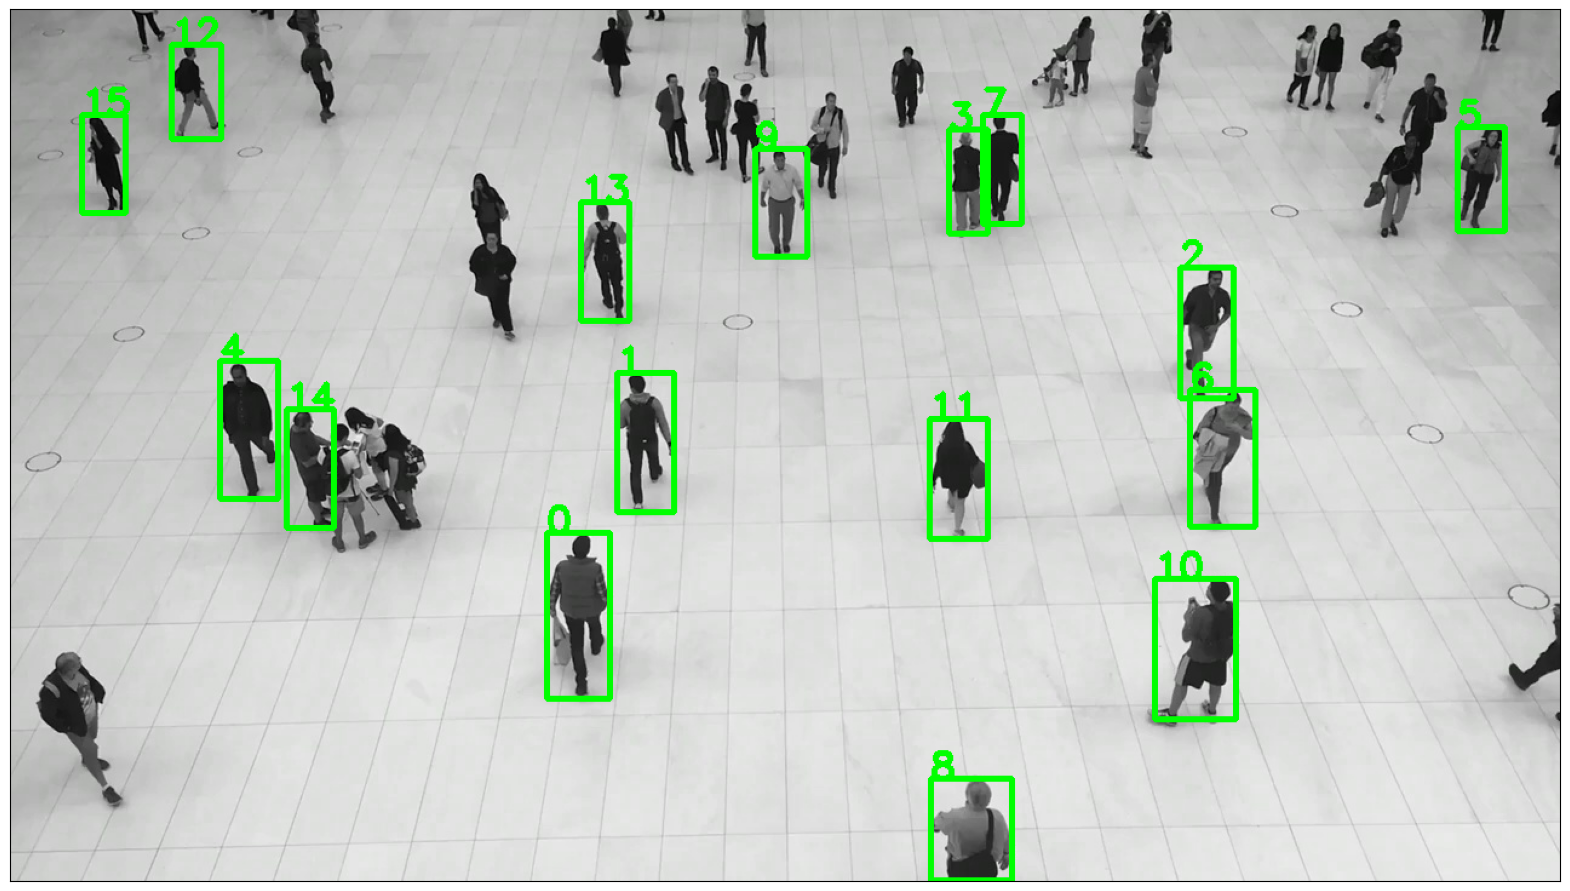

In [14]:
b=object_detection_api('Out\\frame0.jpg', threshold=0.99, text_size=1) 

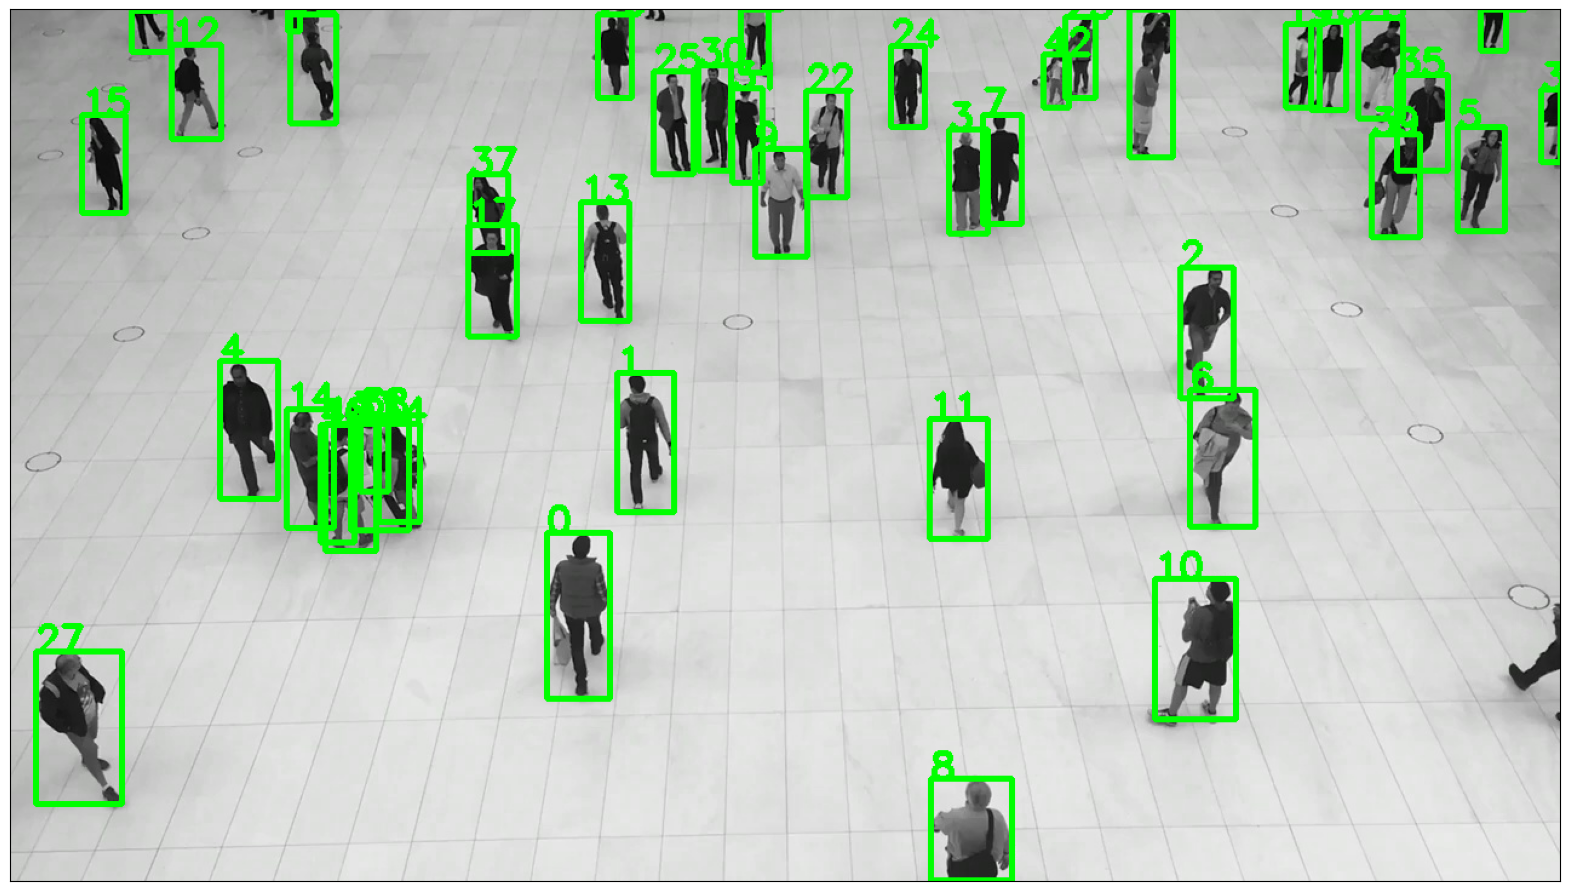

In [15]:
b=object_detection_api('Out\\frame0.jpg', threshold=0.5, text_size=1) 

In [16]:
b

44

### Deployment para toda la BBDD de Imagenes

In [17]:
from datetime import datetime
import pandas as pd
import seaborn as sns

In [ ]:
a=[]
q=[]
for i in range (0,136):
    start_time = datetime.now() # grabar el tiempo al inicio de cada iteración

    q1=object_detection_api("Out\\frame%i.jpg" % i, threshold=0.8, text_size=1) 

    end_time = datetime.now() # grabar el tiempo al finalizar cada predicción
    total=end_time - start_time
    print('Duration: {}'.format(total))
    a.append(total.total_seconds())
    q.append(q1) # agregar a una lista la cantidad de segundos de cada iteración

### Resultados

In [19]:
df = pd.DataFrame({'Duración':a})
df.describe()

,Duración
count,136.000000
mean,3.781259
std,0.414575
min,3.406955
25%,3.502712
50%,3.675627
75%,3.937545
max,6.822814


<Axes: xlabel='Duración', ylabel='Count'>

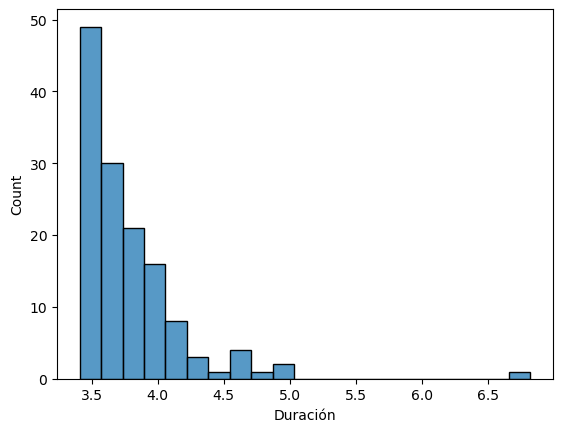

In [20]:
sns.histplot(data=df, x="Duración")

In [22]:
df1 = pd.DataFrame({'Cantidad':q})
df1.describe()

,Cantidad
count,136.000000
mean,33.617647
std,3.806542
min,26.000000
25%,31.000000
50%,33.000000
75%,37.000000
max,42.000000


<Axes: xlabel='Cantidad', ylabel='Count'>

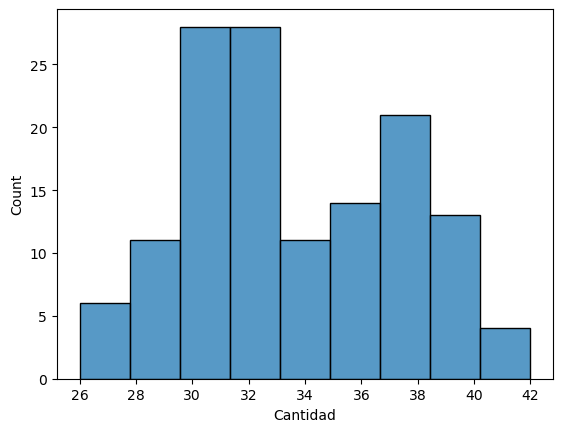

In [24]:
sns.histplot(data=df1, x="Cantidad")

### Discusión

- De las 36 imágenes procesadas el tiempo medio fue de 3.78 segundos. La gran mayoría de las imágenes se demora entre 3 a 4 segundos en ser procesadas, sin embargo, hay una imagen que se demoró más de 6.5 segundos.


- La cantidad de personas detectadas en cada imagen va desde los 26 hasta los 42, con un promedio de 33 personas.


- Se realizó una prueba manual con varias imágenes seleccionadas de manera aleatoria para contar la cantidad de personas reconocidas por la red pre entrenada y la cantidad de personas totales. Si bien es cierto que al utilizar un umbral de detección del 80% ocurre que en algunas imágenes hay 2 personas muy próximas y las cuenta solo como una persona, llegando a un accuracy del 93% (41 personas reconocidas / 44 total de personas). 


- Finalmente, este punto es rápidamente mejorado al llevar el umbral a 50% de detección y, con esto, se alcanza un accuracy del 100%, es decir, se detecta exactamente la misma cantidad de personas que hay en la imagen.
